# Оценка риска ДТП

Каршеринговой компании нужна система, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов. Для обучения модели нужно взять данные за 2012 год с типом участника 'car' и серьезностью происшествия любой кроме 'scratch'. 

Выполнение поставленной задачи будет проходить следующим образом:
- отбор и анализ данных;
- построение моделей машинного обучения;
- выбор и оценка наилучшей модели;
- общие выводы и рекомендации.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Статистический-анализ-факторов-ДТП" data-toc-modified-id="Статистический-анализ-факторов-ДТП-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Статистический анализ факторов ДТП</a></span></li><li><span><a href="#Подготовка-и-анализ-данных-для-модели-оценки-водительского-риска" data-toc-modified-id="Подготовка-и-анализ-данных-для-модели-оценки-водительского-риска-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка и анализ данных для модели оценки водительского риска</a></span></li><li><span><a href="#Обучение-и-выбор-наилучшей-модели" data-toc-modified-id="Обучение-и-выбор-наилучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и выбор наилучшей модели</a></span><ul class="toc-item"><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#CatboostClassifier" data-toc-modified-id="CatboostClassifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatboostClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Анализ-важности-факторов-ДТП" data-toc-modified-id="Анализ-важности-факторов-ДТП-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ важности факторов ДТП</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Обзор данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from IPython.display import Image

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
SEED = 42

Подключение к БД:

In [2]:
#данные для подключения к БД удалены в целях безопасности
db_config = {
    'user': '*****',
    'pwd': '*****',
    'host': '*****',
    'port': 0000,
    'db': '*****'
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

engine = create_engine(connection_string)

ER-диаграмма:

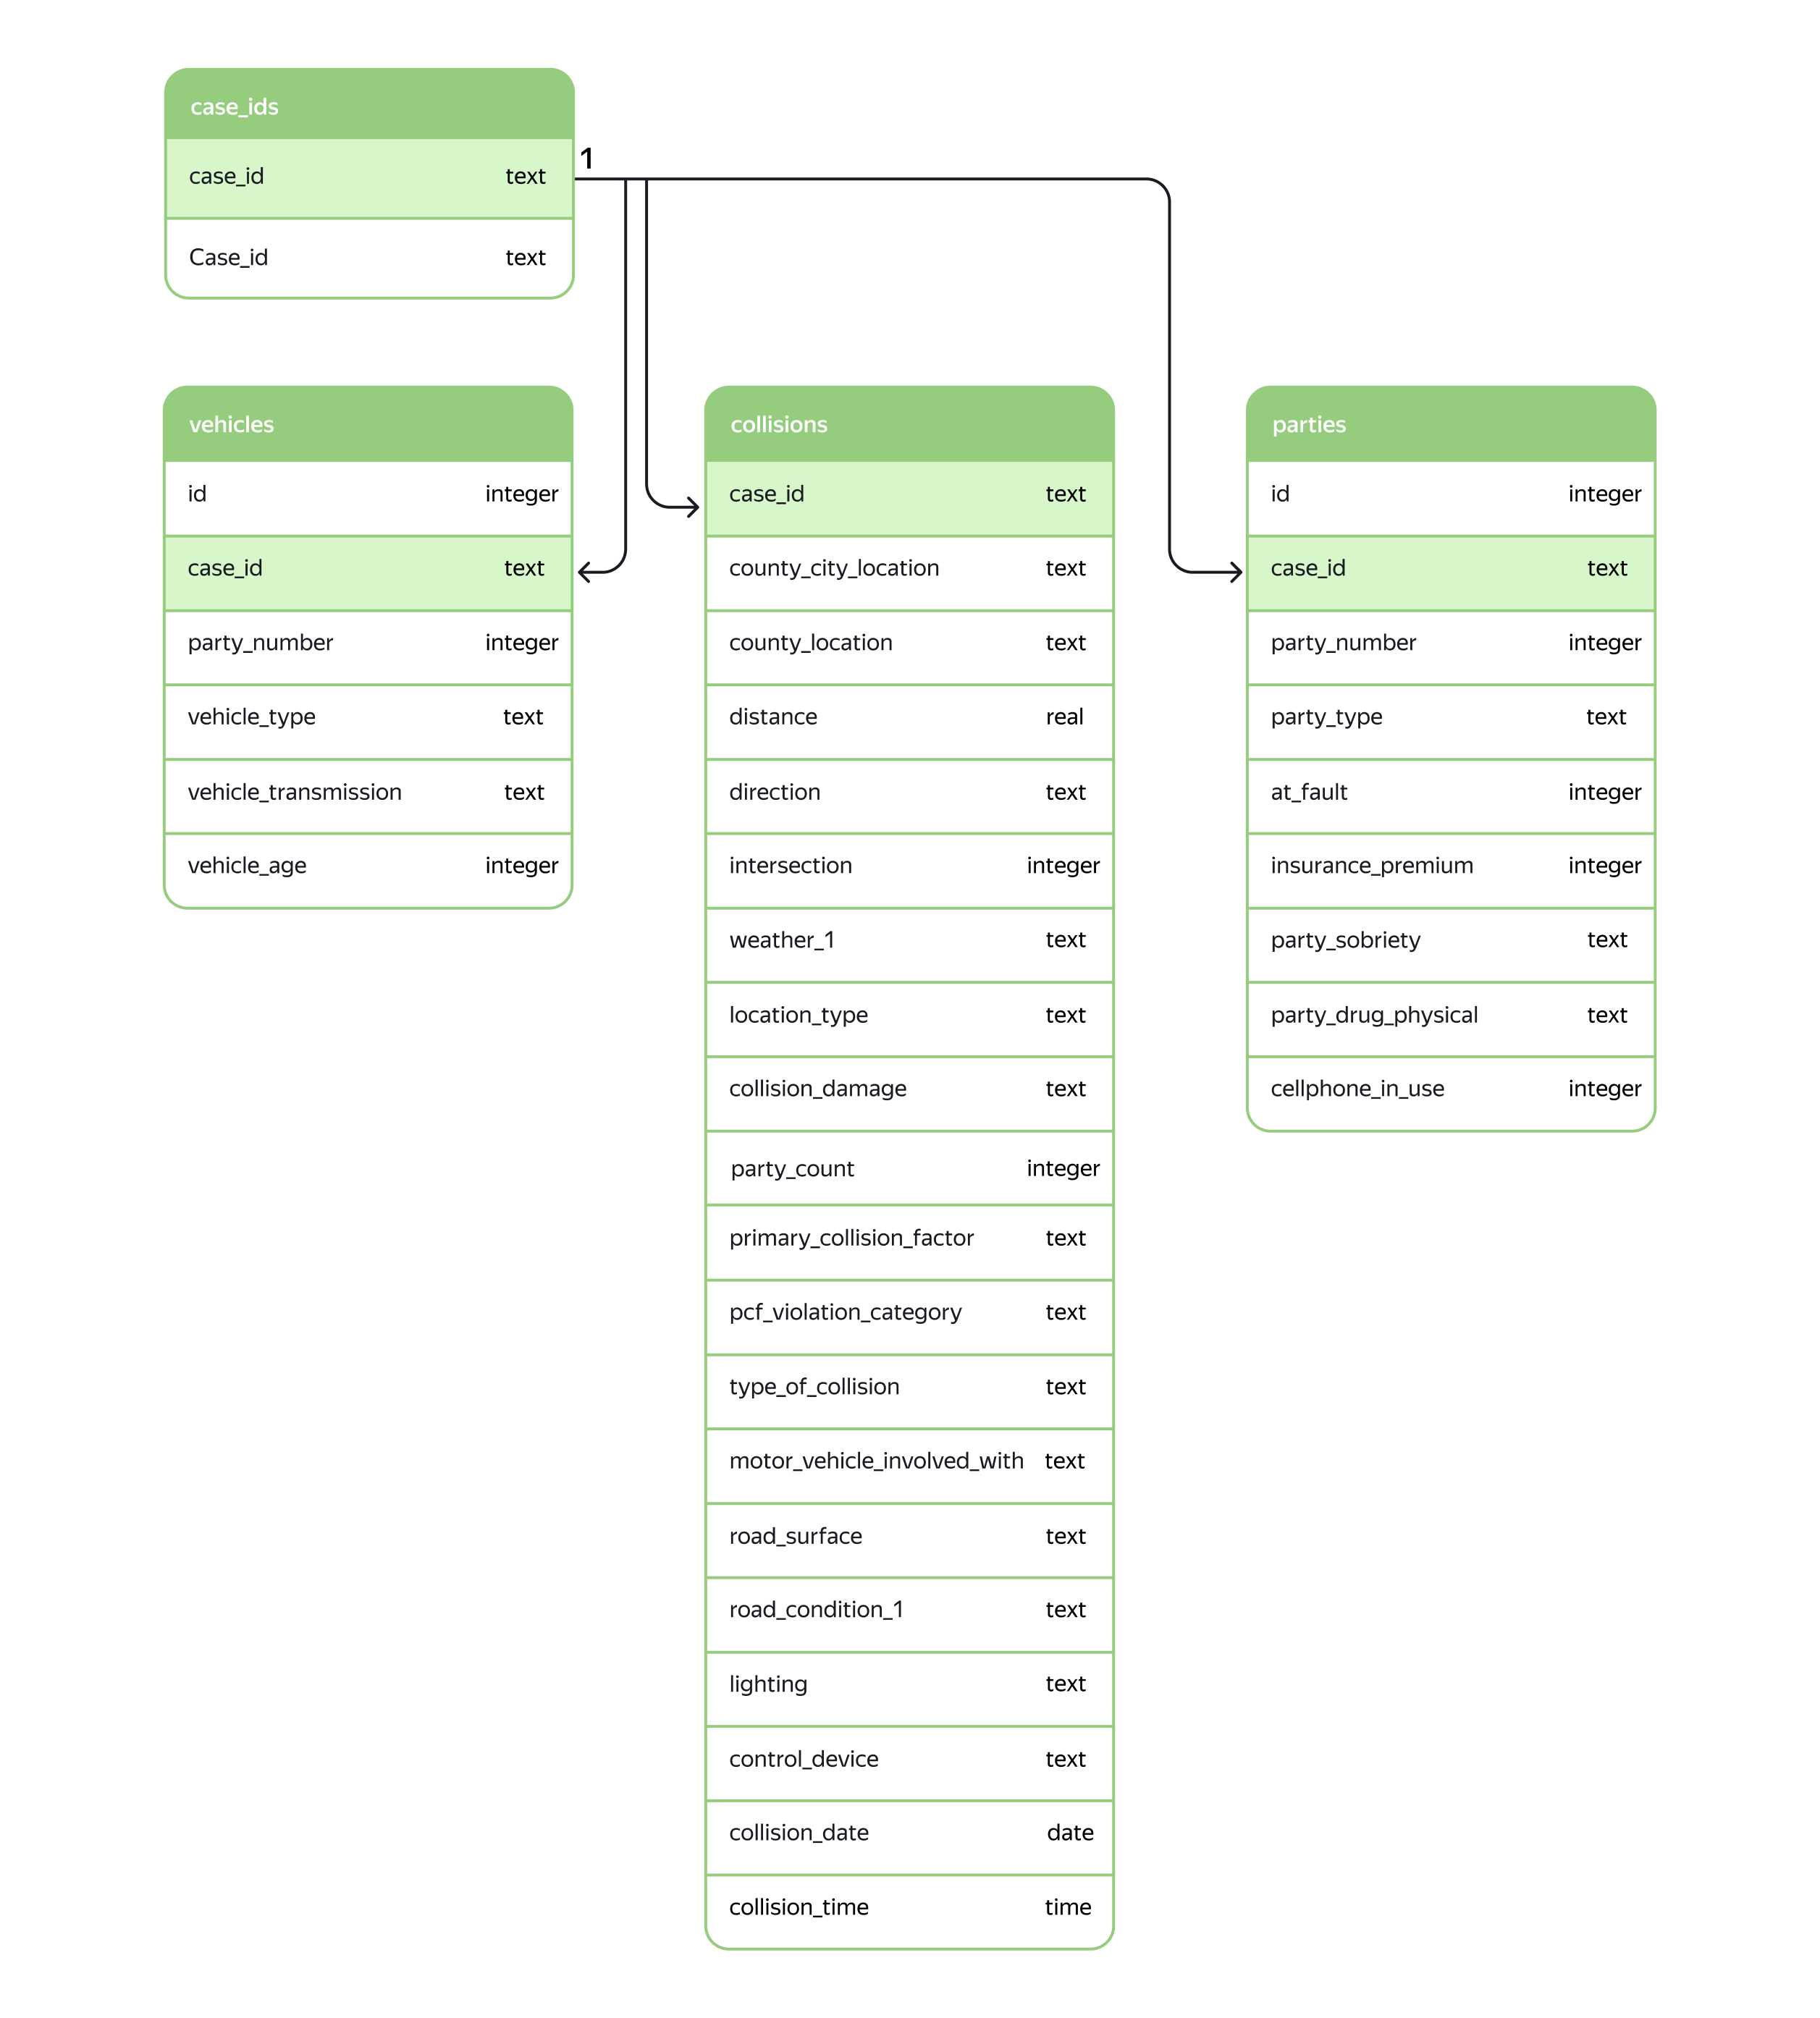

In [3]:
Image("Image.png")

Выведем на экран первые 5 строк каждой таблицы:

In [4]:
tables = ['case_ids', 'collisions', 'parties', 'vehicles']
for table in tables:
    query = f'''
                SELECT *
                FROM {table}
                LIMIT 5;
             '''
    display(table,
            pd.read_sql_query(query, con=engine))

'case_ids'

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


'collisions'

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


'parties'

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


'vehicles'

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [5]:
# уникальные значения поля db_year таблицы case_ids
query = '''
           SELECT DISTINCT db_year
           FROM case_ids;
        '''
pd.read_sql_query(query, con=engine)

,db_year
0,2021


**Выводы:**
В нашем распоряжении 4 таблицы: `case_ids`, `collisions`, `parties` и `vehicles`.
- таблица `case_ids` содержит идентификационный номер зарегистрированного происшествия и год формирования/обновления базы данных. Так как поле `case_id` встречается во всех остальных таблицах, а техническая дата с ДТП никак не связана, то эта таблица в дальнейшем не понадобится;
- таблица `collisions` содержит информацию о происшествии: дату, время, место происшествия, погодные условия, уровень повреждений автомобиля, состояние дороги, освещение и другие факторы;
- таблица `parties` содержит информацию об участниках ДТП: тип участника ДТП, его номер в зависимости от количества участников происшествия, сумма страховки, физическое состояние, трезвость, наличие телефона в автомобиле. Целевой признак - `at_fault` - является ли участник происшествия виновником;
- таблица `vehicles` содержит описание автомобиля: тип кузова, КПП, возраст автомобиля.

Среди имеющихся исторических данных только статистика по случившимся ДТП. Статистика по благополучно заверешенным поездкам отсутствует. Исходя из имеющихся данных, поставленную задачу следует сформулировать следующим образом: возможно ли предсказать станет ли водитель виновником ДТП при условии, что ДТП точно наступит.

Для решения этой задачи будем использовать таблицы `collisions`, `parties` и `vehicles`, у них есть общий ключ - поле `case_id`.

##  Статистический анализ факторов ДТП

Проанализируем в какие месяцы происходит наибольшее количество аварий:

In [6]:
query = '''
           SELECT DISTINCT DATE_TRUNC('month', collision_date)::date as month,
                  COUNT(*) OVER(PARTITION BY DATE_TRUNC('month', collision_date))
           FROM collisions
           ORDER BY month;
        '''
months = pd.read_sql_query(query, con=engine)

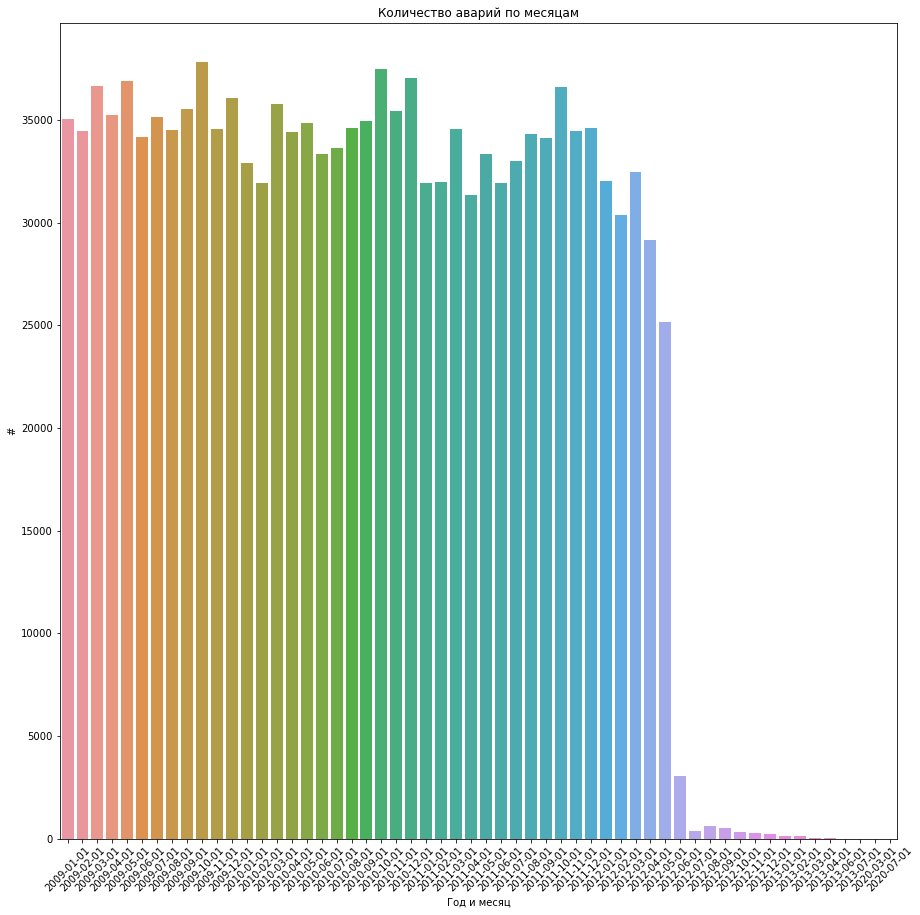

In [7]:
plt.figure(figsize=(15, 15))
sns.barplot(data = months, y = 'count', x = 'month')
plt.xticks(rotation = 45)
plt.xlabel('Год и месяц')
plt.ylabel('#')
plt.title('Количество аварий по месяцам')
None

В выборке мало данных начиная с мая 2012 года. Это может повлиять на общее количество аварий по месяцам за все время. Построим столбчатую диаграмму по данным до 2012 года не включительно.

In [8]:
query = '''
           SELECT DISTINCT EXTRACT(MONTH from collision_date)::int as month,
                  COUNT(*) OVER(PARTITION BY EXTRACT(MONTH from collision_date))
           FROM collisions
           WHERE EXTRACT(YEAR from collision_date) < 2012
           ORDER BY month;
        '''
collisions = pd.read_sql_query(query, con=engine)

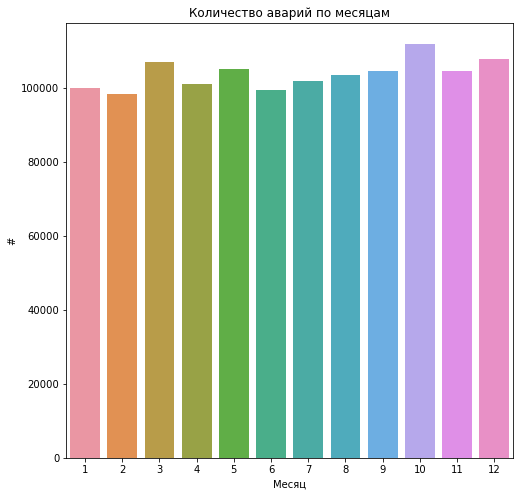

In [9]:
plt.figure(figsize=(8, 8))
sns.barplot(x=collisions['month'], y=collisions['count'])
plt.xlabel('Месяц')
plt.ylabel('#')
plt.title('Количество аварий по месяцам')
None

In [10]:
query = '''
           SELECT COUNT(*)
           FROM collisions
           WHERE EXTRACT(YEAR from collision_date) < 2012
             AND EXTRACT(MONTH from collision_date) = 10;
        '''
pd.read_sql_query(query, con=engine)

,count
0,111933


Наибольшее количество аварий происходит с октября по декабрь и в марте, пик аварий в октябре - 111 933 ДТП. Такая сезонная зависимость может быть связана с погодными условиями - гололед, осадки, плохая видимость.

## Подготовка и анализ данных для модели оценки водительского риска

Выгрузим все данные за 2012 год, с типом участника 'car' и серьезностью происшествия любой кроме 'scratch'. Идентификационные номера происшествий, участников и порядковые номера в выгрузку не войдут. 
Для прогнозирования ДТП нужны такие факторы, которые могут быть известны до начала поездки, а значит информацию о еще не наступивших событиях надо отбросить - это колонки:
- `collision_damage`
- `party_count`
- `primary_collision_factor`
- `pcf_violation_category`
- `type_of_collision`
- `motor_vehicle_involved_with`
- `insurance_premium`

In [11]:
query = '''
           WITH
           c AS (SELECT *
                 FROM collisions
                 WHERE EXTRACT(YEAR from collision_date) = 2012
                       AND collision_damage <> 'scratch'),
           p AS (SELECT *
                 FROM parties
                 WHERE party_type = 'car')

           SELECT c.county_city_location,
                  c.county_location,
                  c.distance,
                  c.direction,
                  c.intersection,
                  c.weather_1,
                  c.location_type,
                  c.road_surface,
                  c.road_condition_1,
                  c.lighting,
                  c.control_device,
                  c.collision_date,
                  c.collision_time,
                  p.at_fault,
                  p.party_sobriety,
                  p.party_drug_physical,
                  p.cellphone_in_use,
                  v.vehicle_type,
                  v.vehicle_transmission,
                  v.vehicle_age
           FROM c
           JOIN p ON c.case_id=p.case_id
           LEFT OUTER JOIN vehicles AS v ON c.case_id=v.case_id
                                        AND v.party_number = p.party_number;
        '''
df = pd.read_sql_query(query, con=engine)

In [12]:
def total_view(df: pd.DataFrame, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return display(pd.concat([
                              df.head(n_rows),
                              df.sample(n_rows, random_state=seed),
                              df.tail(n_rows)
                             ]))

total_view(df)
display(df.describe().T)
df.info()

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,0111,alameda,150.0,north,0.0,clear,ramp,dry,normal,daylight,none,2012-01-04,10:15:00,1,had not been drinking,None,0.0,None,None,NaN
1,3712,san diego,0.0,None,1.0,cloudy,None,dry,other,daylight,none,2012-03-30,07:40:00,1,had not been drinking,None,0.0,None,None,NaN
2,3712,san diego,0.0,None,1.0,cloudy,None,dry,other,daylight,none,2012-03-30,07:40:00,0,had not been drinking,None,0.0,sedan,auto,2.0
3,4312,santa clara,30.0,south,0.0,cloudy,None,dry,normal,daylight,functioning,2012-03-16,14:35:00,1,had not been drinking,None,0.0,None,None,NaN
4,3404,sacramento,0.0,None,1.0,clear,None,dry,normal,daylight,none,2012-04-02,12:54:00,1,had not been drinking,None,0.0,None,None,NaN
89617,1925,los angeles,109.0,west,0.0,clear,None,dry,normal,daylight,none,2012-04-05,15:39:00,0,had not been drinking,None,0.0,coupe,manual,6.0
44077,0109,alameda,0.0,None,1.0,cloudy,None,dry,normal,dark with street lights,functioning,2012-01-31,20:20:00,1,impairment unknown,G,NaN,None,None,NaN
176259,3301,riverside,3960.0,east,0.0,clear,highway,dry,normal,dark with no street lights,none,2012-05-07,03:35:00,0,had not been drinking,None,0.0,None,None,NaN
86228,1903,los angeles,730.0,east,0.0,clear,highway,dry,normal,dark with no street lights,none,2012-02-24,02:18:00,0,"had been drinking, under influence",None,0.0,coupe,manual,3.0
16897,5600,ventura,1436.0,north,0.0,clear,highway,dry,normal,dark with no street lights,none,2012-01-06,06:10:00,0,had not been drinking,None,0.0,None,None,NaN


,count,mean,std,min,25%,50%,75%,max
distance,196837.0,662.478169,7915.264303,0.0,10.0,100.0,500.0,1584000.0
intersection,195850.0,0.201899,0.401419,0.0,0.0,0.0,0.0,1.0
at_fault,196837.0,0.523514,0.499448,0.0,0.0,1.0,1.0,1.0
cellphone_in_use,171464.0,0.023632,0.151899,0.0,0.0,0.0,0.0,1.0
vehicle_age,54554.0,4.856472,3.234503,0.0,3.0,4.0,7.0,161.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   county_city_location  196837 non-null  object 
 1   county_location       196837 non-null  object 
 2   distance              196837 non-null  float64
 3   direction             153975 non-null  object 
 4   intersection          195850 non-null  float64
 5   weather_1             196183 non-null  object 
 6   location_type         87357 non-null   object 
 7   road_surface          195564 non-null  object 
 8   road_condition_1      195694 non-null  object 
 9   lighting              196116 non-null  object 
 10  control_device        195864 non-null  object 
 11  collision_date        196837 non-null  object 
 12  collision_time        195464 non-null  object 
 13  at_fault              196837 non-null  int64  
 14  party_sobriety        193212 non-null  object 
 15  

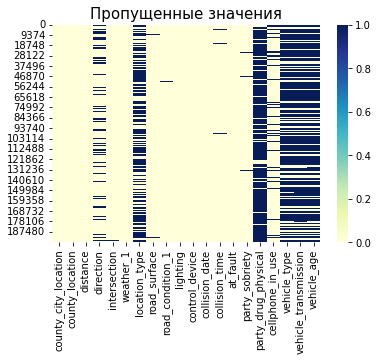

In [13]:
plt.title('Пропущенные значения', fontsize = 15)
sns.heatmap(df.isna(), cmap='YlGnBu')
None

In [14]:
df.isna().sum()

county_city_location         0
county_location              0
distance                     0
direction                42862
intersection               987
weather_1                  654
location_type           109480
road_surface              1273
road_condition_1          1143
lighting                   721
control_device             973
collision_date               0
collision_time            1373
at_fault                     0
party_sobriety            3625
party_drug_physical     171689
cellphone_in_use         25373
vehicle_type            140589
vehicle_transmission    141448
vehicle_age             142283
dtype: int64

- В получившейся таблице 196837 строк и 27 колонок.
- Целевая переменная `at_fault` показывает виновен ли участник происшествия.
- В данных много пропусков, в некоторых колонках тип данных не соответствует содержимому. 
- В колонках `distance` и `vehicle_age` есть выбросы.

Проанализируем данные подробнее. 
Выведем уникальные значения категориальных данных:

In [15]:
categories = ['county_city_location', 'county_location', 'direction',
              'intersection', 'weather_1', 'location_type', 'road_surface',
              'road_condition_1', 'lighting', 'control_device','party_sobriety',
              'party_drug_physical', 'cellphone_in_use', 'vehicle_type',
              'vehicle_transmission'
             ]

for column in categories:
    print(f'{column}:',
          df[column].value_counts(dropna=False),
          f'Всего категорий: {len(df[column].unique())}',
          sep='\n',
          end='\n\n')

county_city_location:
1942    23010
1900     7419
3400     3743
3711     3419
1941     3214
        ...  
1003        1
1009        1
1958        1
1504        1
4112        1
Name: county_city_location, Length: 513, dtype: int64
Всего категорий: 513

county_location:
los angeles        64488
orange             18509
san bernardino     11428
riverside          10776
san diego          10060
alameda             8224
sacramento          7478
santa clara         7018
ventura             4976
contra costa        4333
kern                4252
san mateo           3721
san joaquin         2965
fresno              2954
tulare              2896
santa barbara       2743
stanislaus          2498
sonoma              2381
monterey            2192
placer              2005
solano              1718
san francisco       1704
san luis obispo     1553
santa cruz          1511
marin               1501
merced              1271
yolo                1080
humboldt             957
butte                857
madera

В колонке `county_city_location` слишком много категорий (513), к тому же они входят в состав категорий колонки `county_location`, поэтому ее использовать не будем.

В колонке `county_location` 58 категорий, объединим те из них, в которых было менее 3000 ДТП в одну категорию:

In [16]:
def categories(df, column_name, number, category_name):
    """Объединяет значения из df[column_name], встречающиеся реже количества number
       в выбранную категорию category_name
    """
    values = df[column_name].value_counts(dropna=False)
    idx_list = values[values < number].index
    df.loc[df[column_name].isin(idx_list), column_name] = category_name
    display(df[column_name].value_counts(dropna=False))

In [17]:
categories(df, 'county_location', 3000, 'other')

los angeles       64488
other             41574
orange            18509
san bernardino    11428
riverside         10776
san diego         10060
alameda            8224
sacramento         7478
santa clara        7018
ventura            4976
contra costa       4333
kern               4252
san mateo          3721
Name: county_location, dtype: int64

В `direction` 42862 пропуска, заполним их значением 'unknown': 

In [18]:
df.loc[df['direction'].isna(), 'direction'] = 'unknown'

В колонке `intersection` 987 пропусков, в `location_type` - 109480. Колонки дублируют друг друга относительно информации о месте ДТП - перекрестке. Заполним пропуски в `intersection` по информации из `location_type`, для модели из этих двух колонок будем использовать `intersection`. 

In [19]:
df.loc[(df['intersection'].isna()) & \
       (df['location_type'] == 'intersection'), 'intersection'] = 1

df.loc[(df['intersection'].isna()) \
       & (df['location_type'] != 'intersection') \
       & (~df['location_type'].isna()), 'intersection'] = 0
df['intersection'].value_counts(dropna=False)

0.0    156385
1.0     39555
NaN       897
Name: intersection, dtype: int64

В `weather_1` все значения, кроме пропусков, 'clear' и 'cloudy' отнесем в группу 'other':

In [20]:
categories(df, 'weather_1', 9000, 'other')

clear     157335
cloudy     29497
other       9351
NaN          654
Name: weather_1, dtype: int64

В `road_surface` 1273 пропуска.

В `road_condition_1` все значения, кроме пропущенных и 'normal' определим в группу 'other':

In [21]:
categories(df, 'road_condition_1', 4000, 'other')

normal    189563
other       6131
NaN         1143
Name: road_condition_1, dtype: int64

В `lighting` объединим в категорию 'other' все значения, которые встречаются менее 15000 раз:

In [22]:
categories(df, 'lighting', 15000, 'other')

daylight                   136370
dark with street lights     38095
other                       21651
NaN                           721
Name: lighting, dtype: int64

В `control_device` все значения, кроме 'functioning' отнесем к категории 'none':

In [23]:
categories(df, 'control_device', 1000, 'none')

none           133225
functioning     62639
NaN               973
Name: control_device, dtype: int64

В `party_sobriety` отнесем все значения, кроме 'had not been drinking' к категории 'other':

In [24]:
categories(df, 'party_sobriety', 21000, 'other')

had not been drinking    157684
other                     35528
NaN                        3625
Name: party_sobriety, dtype: int64

В `party_drug_physical`, `cellphone_in_use`, `vehicle_type` и `vehicle_transmission` слишком много пропущенных значений. Не будем использовать эти данные в модели.

Проанализируем числовые данные. 

В колонке `vehicle_age` 142 283 пропущенных значений, но так как обязательное условие заказчика учесть этот фактор, посмотрим на распределение значений и категоризуем данные:

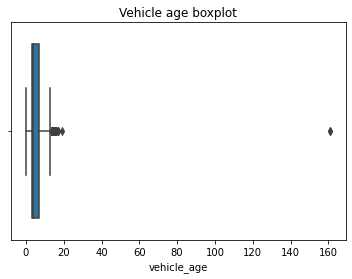

In [25]:
sns.boxplot(data=df, orient='h', x='vehicle_age')
plt.title('Vehicle age boxplot')
None

Уберем строки, в которых возраст автомобиля превышает 30 лет:

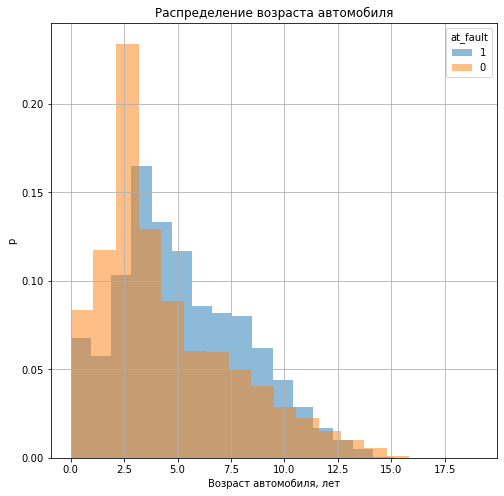

In [26]:
df = df[~(df['vehicle_age'] > 30)]

plt.figure(figsize=(8, 8))
plt.title('Распределение возраста автомобиля')
plt.xlabel('Возраст автомобиля, лет')
plt.ylabel('p')
df.loc[df['at_fault'] == 0 , 'vehicle_age'].hist(bins=18, density=True, alpha=0.5)
df.loc[df['at_fault'] == 1 , 'vehicle_age'].hist(bins=18, density=True, alpha=0.5)
plt.legend(['1', '0'],
           title='at_fault')
None

Виновниками ДТП чаще становятся водители, возраст автомобилей которых не старше 5 лет. Присвоим категории `0` для пропущенных значений, `1` для автомобилей в возрасте до 5 лет включительно и `2` - для автомобилей старше 5 лет.

In [27]:
df.loc[(df['vehicle_age'] >= 0) & (df['vehicle_age'] < 6), 'age_cat'] = 1
df.loc[df['vehicle_age'].isna(), 'age_cat'] = 0
df.loc[df['vehicle_age'] > 5, 'age_cat'] = 2

В колонке `distance` максимальное значение составляет 1 584 000 метров, что похоже на выброс.

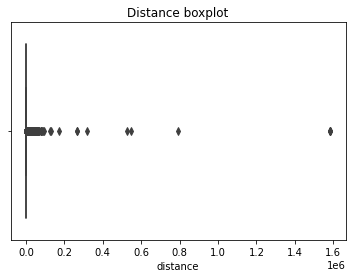

In [28]:
sns.boxplot(data=df, orient='h', x='distance')
plt.title('Distance boxplot')
None

Уберем 2.5% выбросов и посмотрим на распределение:

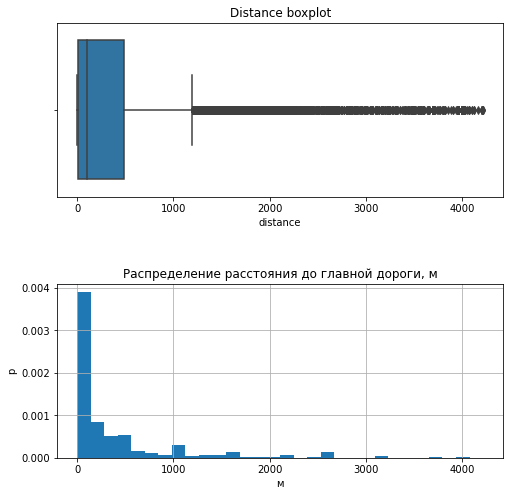

In [29]:
df = df[df['distance'] < np.percentile(df['distance'], 97.5)]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
sns.boxplot(data=df, orient='h', x='distance')
plt.title('Distance boxplot')


plt.subplot(2, 1, 2)
df['distance'].hist(bins=30, density=True)
plt.title('Распределение расстояния до главной дороги, м')
plt.xlabel('м')
plt.ylabel('p')
plt.subplots_adjust(hspace=0.5)
None

Расстояние до главное дороги имеет экспоненциальное распределение. Большинство аварий происходит на главной дороге или вблизи.

Рассмотрим колонки `collision_date` и `collision_time`. Из `collision_date` извлечем месяцы, а `collision_time` категоризуем по часам: часы 7-18 войдут в категорию 0, а 19-6 в категорию 1.

In [30]:
df['month'] = pd.to_datetime(df['collision_date'], format='%Y-%m-%d').dt.month

df['hour'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.hour
df.loc[(df['hour'] >= 7) & (df['hour'] <= 18), 'hour_cat'] = 0
df.loc[(df['hour'] < 7) | (df['hour'] > 18), 'hour_cat'] = 1

Таким образом, для дальнейшей оценки важности, мы отобрали следующие признаки:

In [31]:
columns = ['county_location', # место происшествия, таблица collisions
           'direction',       # направление движения, таблица collisions
           'intersection',    # является ли место происшествия перекрестком, таблица collisions
           'weather_1',       # погодные условия, таблица collisions
           'road_surface',    # состояние дороги исходя из погодных условий, таблица collisions
           'road_condition_1',# состояние дорожного полотна, таблица collisions
           'lighting',        # освещение, таблица collisions
           'control_device',  # устройство управления(круиз контроль?), таблица collisions
           'party_sobriety',  # трезвость участника, таблица parties
           'distance',        # расстояние от главной дороги, таблица collisions
           'month',           # месяц происшествия, таблица collisions
           'hour_cat',        # время суток происшествия (дневное/ночное), таблица collisions
           'age_cat'          # категории возраста автомобиля, таблица vehicles
          ]

# целевая переменная
target = 'at_fault'

# категориальные данные
cat_cols = ['county_location', 'direction', 'intersection', 'weather_1',
            'road_surface', 'road_condition_1', 'lighting', 'control_device',
            'party_sobriety', 'month', 'hour_cat', 'age_cat'
           ]

# числовые данные
num_col = ['distance']

Посчитаем строки с пропущенными данными:

In [32]:
df[columns].isna().any(axis = 1).sum()

8718

8718 это примерно 4.4% датасета. Удалим их:

In [33]:
df = df[columns + [target]]
df = df.dropna(axis=0)
df.shape

(182937, 14)

Всего из датасета было удалено примерно 7% строк. Выведем распределение категориальных данных:

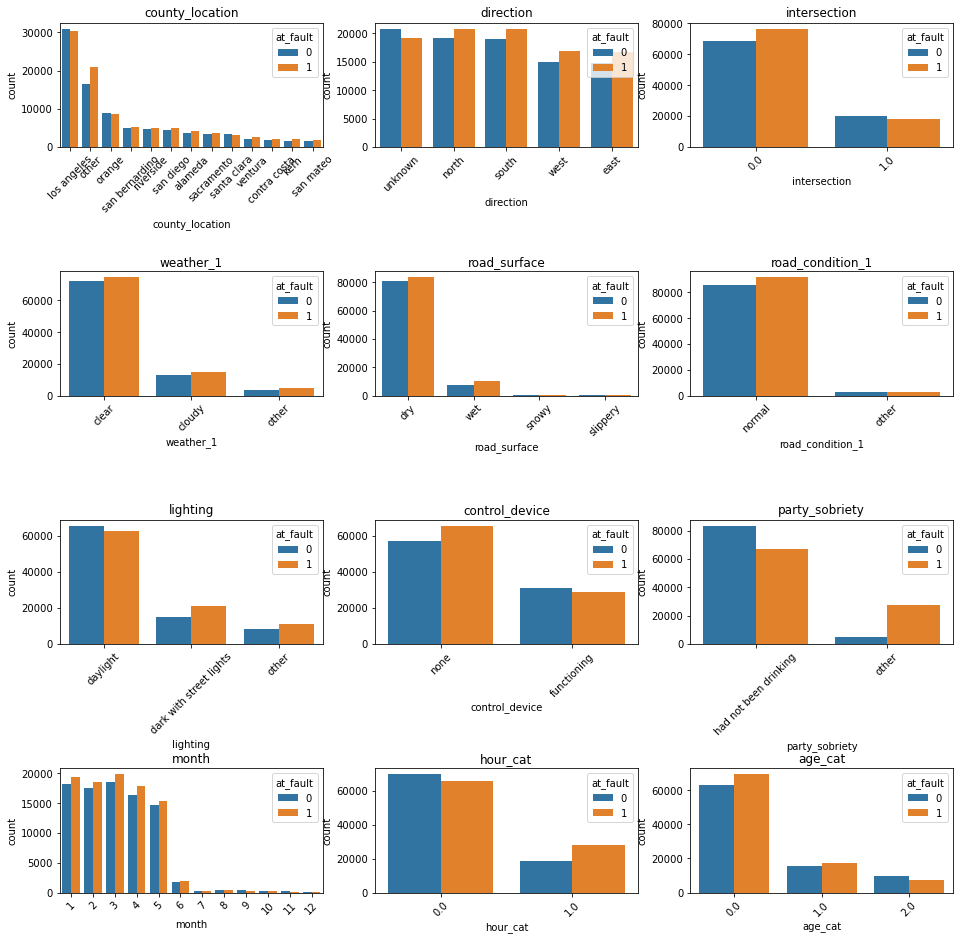

In [34]:
cnt = 1
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=1)
for column in cat_cols:
    plt.subplot(4, 3, cnt)
    tmp = df.groupby('at_fault')[column].value_counts().rename('count').reset_index()
    sns.barplot(data = tmp, y = 'count', x = column, hue = 'at_fault')
    plt.xticks(rotation = 45)
    plt.title(column)
    cnt += 1
    

На графиках видно, что большинство аварий из датасета произошло:
- в Лос-Анджелесе;
- не на перекрестке;
- в ясную сухую погоду;
- на дорожном полотне в нормальном состоянии;
- в дневное время суток;
- аварии происходили преимущественно с января по май.

Доля водителей-виновников ДТП была выше относительно доли невиновных в авариях:
- произошедших в ночное время суток;
- под влиянием алкогольного опьянения;
- возраст автомобиля до 5 лет или не указан;
- с января по май;
- с выключенным устройством управления.

В остальных авариях  в разрезе по категориям различия в соотношении количества виновных/невиновных водителей заметно не выделяются.

Посмотрим на распределение целевой переменной:

In [35]:
df['at_fault'].value_counts(dropna=False, normalize=True)

1    0.515986
0    0.484014
Name: at_fault, dtype: float64

Целевая перменная `at_fault` неплохо сбалансирована - примерно 52% объектов положительного класса и 48% отрицательного.

Посмотрим на коэффициенты модели логистической регрессии:

In [36]:
# OHE
ohe = OneHotEncoder(drop='first')
ohe.fit(df[cat_cols])

df_ohe = ohe.transform(df[cat_cols]).toarray()
cats = ohe.get_feature_names_out()

X = pd.concat([pd.DataFrame(df_ohe, columns=cats),
                     df[num_col].reset_index(drop=True)],axis=1)

#Scaler
scaler = StandardScaler()
scaler.fit(X[num_col])
X[num_col] = scaler.transform(X[num_col])
display(total_view(X))

,county_location_contra costa,county_location_kern,county_location_los angeles,county_location_orange,county_location_other,county_location_riverside,county_location_sacramento,county_location_san bernardino,county_location_san diego,county_location_san mateo,county_location_santa clara,county_location_ventura,direction_north,direction_south,direction_unknown,direction_west,intersection_1.0,weather_1_cloudy,weather_1_other,road_surface_slippery,road_surface_snowy,road_surface_wet,road_condition_1_other,lighting_daylight,lighting_other,control_device_none,party_sobriety_other,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_cat_1.0,age_cat_1.0,age_cat_2.0,distance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.366018
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.597387
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.597387
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.551113
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.597387
154380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.366018
157034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.099317
72322,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.324371
54905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.566537
60815,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328088


None

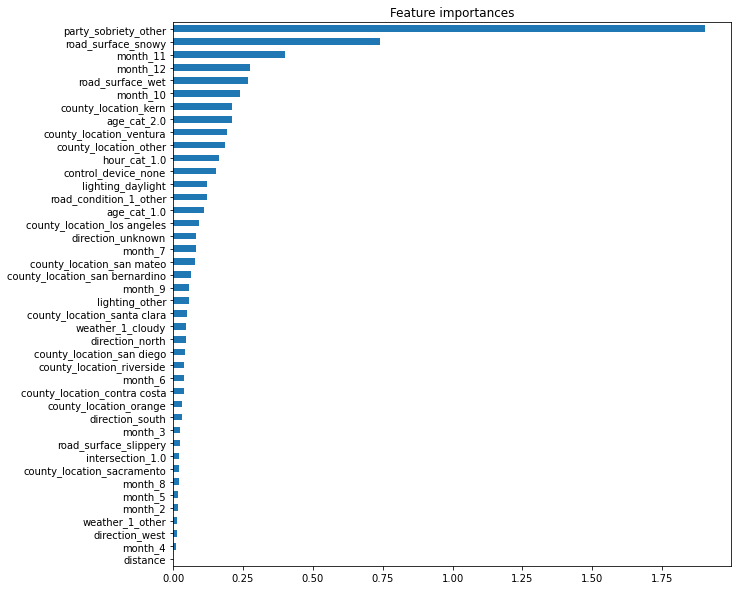

In [37]:
model = LogisticRegression()
model.fit(X, df['at_fault'])

cats = np.append(cats, num_col)

plt.title('Feature importances')
(abs(pd.Series(model.coef_[0],
               index=cats)
    )
 .sort_values()
 .plot(kind='barh',
       figsize=(10,10)
      )
)
None

Признаки `distance`, `wheater_1` и `direction` практически не оказывают влияния, их можно убрать. Самое сильное влияние на модель оказывают признаки трезвости/алкогольного опьянения, возраст автомобиля, состояние дороги исходя из погодных условий, месяц, локация и время суток.

Разделим выборку на обучающую и тестовую. Подготовим данные для моделей LGBMClassifier, CatBoostClassifier и DecisionTreeClassifier.

In [38]:
# обновим список нужных признаков
columns = ['county_location', # место происшествия, таблица collisions
           'intersection',    # является ли место происшествия перекрестком, таблица collisions
           'road_surface',    # состояние дороги исходя из погодных условий, таблица collisions
           'road_condition_1',# состояние дорожного полотна, таблица collisions
           'lighting',        # освещение, таблица collisions
           'control_device',  # устройство управления(круиз контроль?), таблица collisions
           'party_sobriety',  # трезвость участника, таблица parties
           'month',           # месяц происшествия, таблица collisions
           'hour_cat',        # время суток происшествия (дневное/ночное), таблица collisions
           'age_cat'          # категории возраста автомобиля, таблица vehicles
          ]

# целевая переменная
target = 'at_fault'

df = df[columns + [target]]

In [39]:
# для DecisionTreeClassifier

df_dt = df.copy()

ord_cols = ['county_location', 'road_surface', 'road_condition_1',
            'lighting', 'control_device', 'party_sobriety']
encoder = OrdinalEncoder()
df_dt[ord_cols] = encoder.fit_transform(df_dt[ord_cols])

x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(df_dt[columns],
                                                                df_dt['at_fault'],
                                                                test_size=0.1,
                                                                random_state=SEED
                                                               )

print('x_train_dt:',x_train_dt.shape, '\n',
      'y_train_dt:', y_train_dt.shape, '\n',
      'x_test_dt:', x_test_dt.shape, '\n',
      'y_test_dt:', y_test_dt.shape)

total_view(x_train_dt)
total_view(x_test_dt)

x_train_dt: (164643, 10) 
 y_train_dt: (164643,) 
 x_test_dt: (18294, 10) 
 y_test_dt: (18294,)


,county_location,intersection,road_surface,road_condition_1,lighting,control_device,party_sobriety,month,hour_cat,age_cat
35391,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,1.0,0.0
179038,5.0,0.0,0.0,0.0,1.0,0.0,0.0,5,0.0,2.0
111706,3.0,1.0,0.0,0.0,1.0,1.0,1.0,3,0.0,0.0
110849,5.0,0.0,0.0,0.0,0.0,1.0,0.0,4,1.0,0.0
150909,5.0,0.0,0.0,0.0,1.0,0.0,0.0,5,0.0,0.0
23006,5.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0.0,0.0
119982,3.0,0.0,0.0,0.0,1.0,1.0,0.0,3,0.0,0.0
160686,0.0,0.0,0.0,0.0,1.0,1.0,0.0,5,0.0,0.0
19833,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0.0,0.0
69344,3.0,1.0,0.0,0.0,1.0,0.0,0.0,2,1.0,0.0


,county_location,intersection,road_surface,road_condition_1,lighting,control_device,party_sobriety,month,hour_cat,age_cat
26453,3.0,0.0,0.0,0.0,1.0,0.0,0.0,2,0.0,0.0
96978,3.0,0.0,3.0,0.0,0.0,1.0,0.0,3,1.0,0.0
67766,1.0,0.0,3.0,0.0,1.0,1.0,0.0,3,0.0,1.0
99838,3.0,0.0,0.0,0.0,0.0,1.0,1.0,3,1.0,0.0
193052,8.0,0.0,0.0,0.0,1.0,0.0,0.0,5,0.0,2.0
192489,3.0,0.0,0.0,0.0,1.0,1.0,0.0,6,0.0,1.0
133973,6.0,0.0,0.0,0.0,0.0,1.0,0.0,4,1.0,0.0
51926,2.0,1.0,0.0,0.0,1.0,1.0,0.0,3,0.0,0.0
183822,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,0.0,1.0
16453,5.0,0.0,0.0,0.0,1.0,1.0,0.0,1,0.0,0.0


In [40]:
# для CatboostClassifier и LGBMClassifier

df_cb = df.copy()

df_cb[['intersection', 'hour_cat', 'age_cat']] = df_cb[['intersection', 'hour_cat', 'age_cat']].astype('int8')
df_cb[columns] = df_cb[columns].astype('category')
x_train_cb, x_test_cb, y_train_cb, y_test_cb = train_test_split(df_cb[columns],
                                                                df_cb['at_fault'],
                                                                test_size=0.1,
                                                                random_state=SEED
                                                               )

print('x_train_cb:',x_train_cb.shape, '\n',
      'y_train_cb:', y_train_cb.shape, '\n',
      'x_test_cb:', x_test_cb.shape, '\n',
      'y_test_cb:', y_test_cb.shape)

total_view(x_train_cb)
total_view(x_test_cb)

x_train_cb: (164643, 10) 
 y_train_cb: (164643,) 
 x_test_cb: (18294, 10) 
 y_test_cb: (18294,)


,county_location,intersection,road_surface,road_condition_1,lighting,control_device,party_sobriety,month,hour_cat,age_cat
35391,alameda,0,dry,normal,dark with street lights,none,other,1,1,0
179038,other,0,dry,normal,daylight,functioning,had not been drinking,5,0,2
111706,los angeles,1,dry,normal,daylight,none,other,3,0,0
110849,other,0,dry,normal,dark with street lights,none,had not been drinking,4,1,0
150909,other,0,dry,normal,daylight,functioning,had not been drinking,5,0,0
80186,other,0,dry,normal,daylight,none,had not been drinking,2,0,0
70507,los angeles,0,dry,normal,dark with street lights,functioning,other,2,1,0
33787,santa clara,0,dry,normal,dark with street lights,none,had not been drinking,1,0,0
10121,orange,0,dry,normal,other,none,had not been drinking,1,0,0
97932,orange,0,dry,normal,daylight,none,had not been drinking,3,0,0


,county_location,intersection,road_surface,road_condition_1,lighting,control_device,party_sobriety,month,hour_cat,age_cat
26453,los angeles,0,dry,normal,daylight,functioning,had not been drinking,2,0,0
96978,los angeles,0,wet,normal,dark with street lights,none,had not been drinking,3,1,0
67766,contra costa,0,wet,normal,daylight,none,had not been drinking,3,0,1
99838,los angeles,0,dry,normal,dark with street lights,none,other,3,1,0
193052,san bernardino,0,dry,normal,daylight,functioning,had not been drinking,5,0,2
68869,los angeles,0,dry,normal,dark with street lights,none,other,3,1,0
104889,orange,1,dry,normal,daylight,none,other,3,0,0
184286,ventura,0,dry,normal,daylight,none,had not been drinking,6,0,0
20287,other,0,dry,normal,dark with street lights,functioning,had not been drinking,1,0,1
85960,san bernardino,0,dry,normal,daylight,none,had not been drinking,2,0,1


**Выводы:**
- проведено исследование и отбор признаков для моделей. В финальную модель вошли следующие колонки: 'county_location', 'intersection', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'party_sobriety', 'month', 'hour_cat' и целевая переменная 'at_fault';
- в ходе анализа выявлено, что наибольшее влияние на риск ДТП оказывают факторы трезвости водителя, возраст автомобиля, состояние дороги исходя из погодных условий, месяц, локация и время суток;
- были отклонены признаки, описывающие события, не известные до начала поездки, признаки с большим количеством пропущенных значений и признаки с наименьшими весами в модели логистической регрессии (и вместе с тем по своему смыслу не имеющими прямого отношения к риску ДТП);
- данные были подготовлены для моделей DecisionTreeClassifier, CatboostClassifier и LGBMClassifier и разделены на обучающую и тестовую выборки.

## Обучение и выбор наилучшей модели

Подберем параметры и проверим результаты на тесте. В качестве метрики будем использовать roc-auc, потому что нам важно, чтобы модель с большей степенью уверенности прогнозировала классы.

### DecisionTreeClassifier

In [41]:
model_dt = DecisionTreeClassifier(random_state=SEED)
param_grid = {'max_depth': range(4, 8)}
grid = GridSearchCV(model_dt, param_grid=param_grid, cv=5, scoring='roc_auc')
grid.fit(x_train_dt, y_train_dt)

print(f'ROC-AUC valid: {round(grid.best_score_, 4)}',
      f'Наилучшие параметры:', 
      f'max_depth: {grid.best_params_["max_depth"]}',
      sep='\n')

ROC-AUC valid: 0.6516
Наилучшие параметры:
max_depth: 7


In [42]:
prob_test = grid.predict_proba(x_test_dt)
print('ROC-AUC test:', round(roc_auc_score(y_test_dt, prob_test[:, 1]), 4))

ROC-AUC test: 0.6523


### CatboostClassifier

In [43]:
model_cb = CatBoostClassifier(loss_function='Logloss',
                              eval_metric='AUC',
                              cat_features=columns,
                              random_state=SEED,
                              verbose=False,
                              custom_metric='AUC:hints=skip_train~false',
                              metric_period=20
                             )
param_grid = {'depth': [4, 5, 6, 7, 8],
              'iterations': [160, 180, 200, 220]
             }
model_cb.grid_search(param_grid=param_grid,
                     X=x_train_cb,
                     y=y_train_cb,
                     cv=5
                    )

print(f'ROC-AUC valid: {round(model_cb.get_best_score()["learn"]["AUC"], 4)}',
      'Наилучшие параметры:',
      f'depth: {model_cb.get_params()["depth"]}',
      f'iterations: {model_cb.get_params()["iterations"]}',
      sep='\n')


bestTest = 0.6493753656
bestIteration = 159

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.6493754	best: 0.6493754 (0)	total: 3.42s	remaining: 1m 4s

bestTest = 0.6494235388
bestIteration = 179

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.6494235	best: 0.6494235 (1)	total: 7.13s	remaining: 1m 4s

bestTest = 0.6500690683
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.6500691	best: 0.6500691 (2)	total: 12.2s	remaining: 1m 9s

bestTest = 0.6502051518
bestIteration = 219

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.6502052	best: 0.6502052 (3)	total: 17.9s	remaining: 1m 11s

be

In [44]:
prob_test_cb = model_cb.predict_proba(x_test_cb)
print('ROC-AUC test:', round(roc_auc_score(y_test_cb, prob_test_cb[:, 1]), 4))

ROC-AUC test: 0.6538


### LGBMClassifier

In [45]:
model_lgbm = LGBMClassifier(random_state=SEED, metric='auc')
param_grid = {'max_depth': [3, 4, 5, 6, 7],
              'n_estimators': [40, 50, 60, 70, 80, 90]
              }
grid = GridSearchCV(model_lgbm, param_grid=param_grid, cv=5, scoring='roc_auc')
grid.fit(x_train_cb, y_train_cb)

print(f'ROC-AUC: {round(grid.best_score_, 4)}',
      'Наилучшие параметры:',
      f'max_depth: {grid.best_params_["max_depth"]}',
      f'n_estimators: {grid.best_params_["n_estimators"]}',
      sep='\n')

ROC-AUC: 0.6554
Наилучшие параметры:
max_depth: 3
n_estimators: 70


In [46]:
prob_test_lgbm = grid.predict_proba(x_test_cb)
print('ROC-AUC test:', round(roc_auc_score(y_test_cb, prob_test_lgbm[:, 1]), 4))

ROC-AUC test: 0.6559


Объединим полученные результаты в таблицу:

In [47]:
result = pd.DataFrame({'ROC-AUC valid': [0.6516, 0.6983, 0.6554],
                       'ROC_AUC test':[0.6523, 0.6538, 0.6559],
                       'max_depth': [7, 8, 3],
                       'n_estimators': ['-', 220, 70]},
                      index=['DecisionTree', 'CatBoost', 'LGBM'])
result

,ROC-AUC valid,ROC_AUC test,max_depth,n_estimators
DecisionTree,0.6516,0.6523,7,-
CatBoost,0.6983,0.6538,8,220
LGBM,0.6554,0.6559,3,70


**Выводы:**
- на валидационной выборке наилучший результат у CatBoostClassifier - метрика roc-auc составила 0.6983, однако модель немного переобучилась и на тесте roc-auc составила 0.6538;
- LGBMClassifier показал более стабильные результаты - на валидционной выборке 0.6554, на тестовой 0.6559;
- метрика указанных моделей не намного превысила roc-auc DecisionTreeClassifier (0.6516 на валидационной выборке и 0.6523 на тесте).

## Анализ важности факторов ДТП

Построим матрицу ошибок модели CatBoostClassifier:

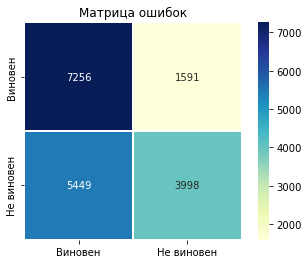

In [48]:
sns.heatmap(confusion_matrix(y_test_cb, model_cb.predict(x_test_cb)),
            cmap='YlGnBu',
            square=True, 
            linewidths=0.1,
            annot=True,
            fmt='d', 
            xticklabels=['Виновен', 'Не виновен'], 
            yticklabels=['Виновен', 'Не виновен']
           ).set_title('Матрица ошибок')
None

Модель верно предсказала 7256 объектов положительного класса и 3998 отрицательного.

Посмотрим как факторы влияют на вероятнось ДТП на основе модели CatBoostClassifier:

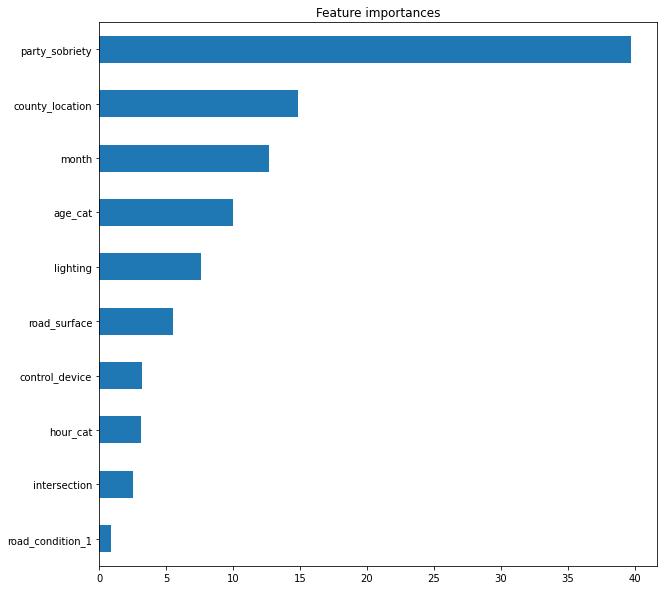

In [49]:
plt.title('Feature importances')
(abs(pd.Series(model_cb.feature_importances_,
               index=model_cb.feature_names_)
    )
 .sort_values()
 .plot(kind='barh',
       figsize=(10,10)
      )
)
None

Самый важный фактор ДТП по мнению модели - уровень трезвости водителя. Также заметное влияние оказывают место и месяц аварии, возраст автомобиля и освещение.

Посмотрим на зависимость целевой переменной от уровня трезвости водителя:

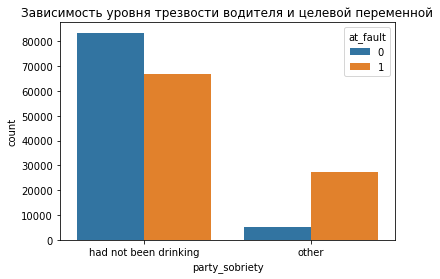

In [50]:
sobriety = df.groupby('at_fault')['party_sobriety'] \
             .value_counts() \
             .rename('count') \
             .reset_index()
sns.barplot(data = sobriety, y = 'count', x = 'party_sobriety', hue = 'at_fault')
plt.title('Зависимость уровня трезвости водителя и целевой переменной')
None

Водители в состоянии алгокольного опьянения в подавляющем большинстве аварий являлись виновниками, среди аварий с участием трезвых водителей, водитель чаще всего был невиновен.

Недопущение за руль пьяного водителя поможет значительно снизить риск ДТП и сократить убытки компании. Для этого необходимо, чтобы автомобиль не заводился без подтверждения трезвости водителя. Например, можно оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место.

## Выводы

- Наилучшая модель на валидационной выборке CatBoostClassifier с глубиной 8 и количеством оценщиков 220 (roc-auc на валидационной выборке 0.6983). На тестовой выборке лучше всего себя показала модель LGBMClassifier с глубиной 3 и количеством оценщиков 70 (roc-auc на тестовой выборке 0.6559);
- самое большое влияение на риск ДТП оказывает уровень трезвости водителя;
- оценка риска при выдаче авто кажется вполне осуществимой задачей, но для этого нужно больше персональной информации о водителе:
  * водительский стаж;
  * количество ДТП за последние несколько лет, в которых водитель был виновником;
  * возраст водителя;
  * пол водителя.
  
Как правило, такая информация имеется у страховых компаний.